In [147]:
import pandas as pd
import numpy as np
import joblib

from scipy.spatial.distance import cosine, jensenshannon
from sklearn.preprocessing import normalize

from tqdm import tqdm

In [151]:
with open('Results/Official_TopicModel_80k.pkl','rb') as File:
    models = joblib.load(File)
    
all_df = pd.read_csv('Results/All_speeches_labelled.csv')

In [152]:
def select_data(year):
    """
    convenience function for extracting X,Y data and dataframe
    """
    sub_df = all_df.loc[all_df.year_x == year]
    model = [mod for mod in models['window_models'] if mod['year'] == year][0]    
    W = normalize(model['W'])
    
    return W,sub_df[['party_y','speaker']].reset_index()

In [153]:
def get_avg_dist_partisan(df,W,speaker):
    speaker_df_index = df.loc[df.speaker == speaker].index
    speaker_W = W[speaker_df_index,:]
    return np.mean(speaker_W,0)


def run_pairwise_cos(mat):
    cos = []
    for i,dist in enumerate(mat):
        for ii, dist2 in enumerate(mat):
            if i != ii:
                cos.append(1 - jensenshannon(dist,dist2))
    mean = np.mean(cos)
    std = np.std(cos)
    return mean,std

In [154]:
def Run_year(year):
    W,df = select_data(year)

    row = {}

    speakers = df.groupby('speaker').first().reset_index()

    avg_dists = []
    for speaker in speakers.iterrows():
        speaker = speaker[1]
        avg_dist = get_avg_dist_partisan(df,W,speaker.speaker)
        avg_dists.append({"speaker":speaker.speaker,'party':speaker.party_y,'dist':avg_dist})

    year_df = pd.DataFrame(avg_dists)

    D_matrix = np.array([x for x in year_df.loc[year_df.party == 'D','dist'].values])
    R_matrix = np.array([x for x in year_df.loc[year_df.party == 'R','dist'].values])

    row['D_mean'],row['D_std'] = run_pairwise_cos(D_matrix)
    row['R_mean'],row['R_std'] = run_pairwise_cos(R_matrix)

    row['year'] = year
    return row

In [155]:
consolidation = []
for year in tqdm(range(1983,2017)):
    consolidation.append(Run_year(year))

100%|██████████| 34/34 [02:59<00:00,  5.29s/it]


In [156]:
all_df = pd.DataFrame(consolidation)

<AxesSubplot:xlabel='year'>

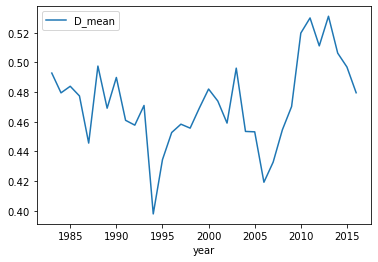

In [160]:
all_df.plot(x='year',y='D_mean')

In [161]:
all_df.to_csv('Results/consolidation.csv')